In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from importlib import reload
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import wandb


In [2]:
from models import *
from data_proc import *
from models import *
from wandb_logging import *

In [3]:
# prompt: I have 3 folders in my computer (depth with the depth images, rgb with rgb and encoded with encoded images), I want to use them for my path

# Define the base directory containing your data folders
base_dir = r'/bigdata/hadassa/PSFMMDE-Remote/Datasets/vkittiv2' # Replace with the actual path to your data directory
# Construct paths to the individual folders
depth_dir = os.path.join(base_dir, 'depths')
rgb_dir = os.path.join(base_dir, 'rgbs')
encoded_dir = os.path.join(base_dir, 'TPs')

Number of batches: 112
Total samples: 447
Batch size: 4
Encoded image shape: torch.Size([3, 256, 256])
RGB image shape: torch.Size([3, 256, 256])
Depth image shape: torch.Size([1, 256, 256])
0.011825742 1.0
0.0 0.9529412
0.0 0.77254903
0.022354467 1.0
0.0 0.9764706
0.011764706 0.7882353
0.014496071 1.0
0.0 1.0
0.0 0.8156863
0.013382162 1.0
0.0 1.0
0.0 0.84313726


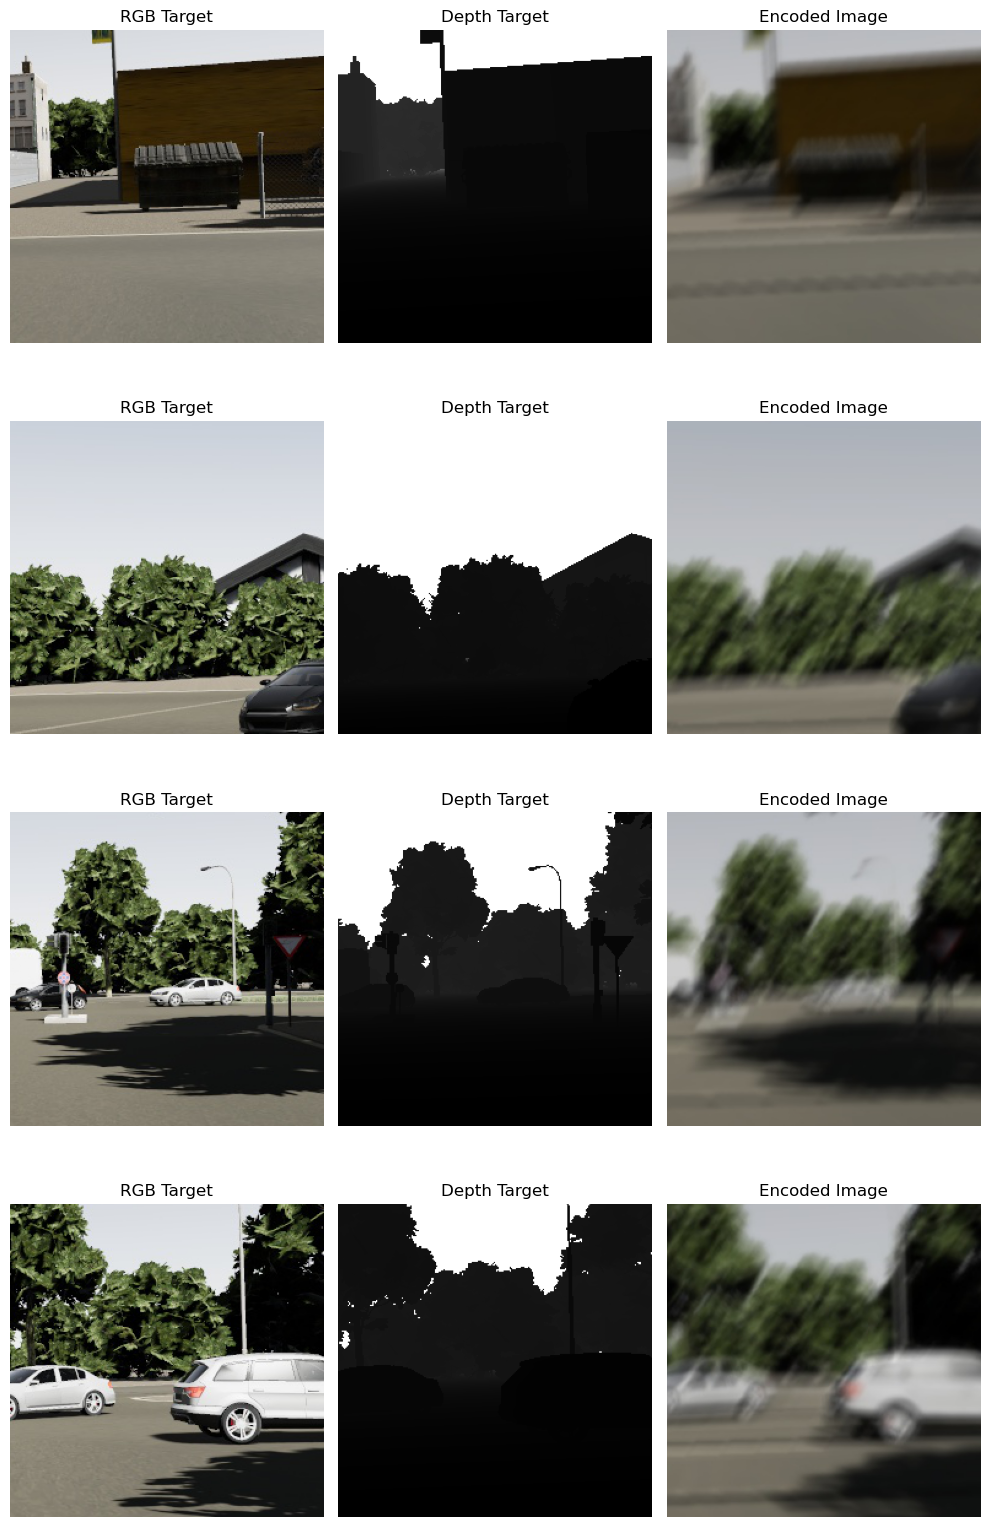

In [4]:
# Get the list of file paths
train_encoded_paths = list_image_files(encoded_dir)
train_rgb_paths = list_image_files(rgb_dir)
train_depth_paths = list_image_files(depth_dir)

# You should add checks here to ensure that the number of files in each directory is the same
if not (len(train_encoded_paths) == len(train_rgb_paths) == len(train_depth_paths)):
    print("Warning: Number of files in depth, rgb, and encoded directories do not match.")
    print(len(train_encoded_paths), len(train_rgb_paths), len(train_depth_paths))
    # You might want to raise an error or handle this discrepancy based on your needs

# Create Datasets and DataLoaders
train_dataset = ImageDataset(train_encoded_paths, train_rgb_paths, train_depth_paths, transform=transform, crop_size=256)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

summarize_data(train_loader, train_dataset)
visualize_data(train_loader)

In [5]:
# del model
# torch.cuda.empty_cache()
from models import *
# Initialize model, loss functions, and optimizer
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = MIMO_UNet().to(device) # MIMOUNet().to(device)

In [6]:
# Total parameters
total_params = sum(p.numel() for p in model.parameters())

# Trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params, trainable_params)
# del model
# torch.cuda.empty_cache()

# for i in range(torch.cuda.device_count()):
#     print(f"GPU {i}:")
#     print(f"  Allocated: {torch.cuda.memory_allocated(i)/1024**2:.2f} MB")
#     print(f"  Cached   : {torch.cuda.memory_reserved(i)/1024**2:.2f} MB")


31390916 31390916


In [7]:
# Define loss functions
# For RGB output (regression on pixel values, typically use L1 or L2)
rgb_criterion = nn.L1Loss()
# For Depth output (regression on pixel values, typically use L1 or L2)
depth_criterion = nn.L1Loss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
num_epochs = 10000


In [14]:
wandb.init(project="mimo_unet_depth_rgb", name="exp_2", config={
    "epochs": num_epochs,
    "batch_size": train_loader.batch_size,
    "lr": optimizer.param_groups[0]["lr"]
})
config = wandb.config

batch_depth_loss,▁
batch_rgb_loss,▁
batch_total_loss,▁
batch_depth_loss,0.42351
batch_rgb_loss,0.53632
batch_total_loss,0.95983


In [ ]:
loss_rgb_list = []; loss_depth_list = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    prog_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (encoded_images, rgb_targets, depth_targets) in enumerate(prog_bar):
        encoded_images = encoded_images.to(device)
        rgb_targets = rgb_targets.to(device)
        depth_targets = depth_targets.to(device)
        optimizer.zero_grad()

        # outputs = model(encoded_images)
        rgb_outputs, depth_outputs = model(encoded_images)
        # print([o.cpu().detach().numpy().shape for o in outputs])
        # Ensure depth targets are the same shape as depth outputs (single channel)
        # If depth_targets was loaded as (B, 3, H, W) due to transform, squeeze the channel dim
        if depth_targets.ndim == 4 and depth_targets.shape[1] == 1:
             pass
        elif depth_targets.ndim == 4 and depth_targets.shape[1] == 3:
            depth_targets = depth_targets[:, :1, :, :] # Take one channel

        loss_rgb = rgb_criterion(rgb_outputs, rgb_targets)
        loss_depth = depth_criterion(depth_outputs, depth_targets)
        total_loss = loss_rgb + loss_depth
        wandb.log({
                    "batch_total_loss": total_loss.item(),
                    "batch_rgb_loss": loss_rgb.item(),
                    "batch_depth_loss": loss_depth.item()
                  })
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item() * encoded_images.size(0)
        loss_rgb_list.append(loss_rgb.item()); loss_depth_list.append(loss_depth.item())
        prog_bar.set_postfix(loss=running_loss)
        if i % 50 == 0:
            step_info = {"epoch": epoch, "batch": i}
            log_pred_gt(rgb_outputs[0], rgb_targets[0], depth_outputs[0], depth_targets[0], step_info)

    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {total_loss.item():.4f}')
        print(f'RGB Loss: {loss_rgb.item():.4f}, Depth Loss: {loss_depth.item():.4f}')
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        axs[0].imshow(rgb_targets[0].cpu().numpy().transpose(1, 2, 0))
        axs[1].imshow(encoded_images[0].cpu().numpy().transpose(1, 2, 0))
        axs[2].imshow(rgb_outputs[0].cpu().detach().numpy().transpose(1, 2, 0))
        plt.show()
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        arr_depths = depth_targets[0].cpu().detach().numpy().transpose(1, 2, 0)
        unique_vals = np.unique(arr_depths)
        second_max = unique_vals[-2] if unique_vals[-1] >= 0.999 else unique_vals[-1]
        arr_clipped = np.clip(arr_depths, 0, second_max)
        print(second_max)
        a0 = axs[0].imshow(arr_clipped); fig.colorbar(a0, ax=axs[0])
        a1 = axs[1].imshow(depth_outputs[0].cpu().detach().numpy().transpose(1, 2, 0)); fig.colorbar(a1, ax=axs[1])
        plt.show()
        if epoch % 100 == 0:
          # Create directory for checkpoints
          chpts_dir = os.path.join(base_dir, 'checkpoints')
          os.makedirs(chpts_dir, exist_ok=True)

          # Get current date and time
          timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

          # File path with timestamp
          checkpoint_path = f"{chpts_dir}/model_epoch{epoch}_{timestamp}.pth"

          # Save checkpoint
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
          }, checkpoint_path)

          print(f"Checkpoint saved to {checkpoint_path}")


    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print('Finished Training')


In [ ]:
summarize_model()

Input size: torch.Size([1, 3, 256, 256])
inc output size: torch.Size([1, 64, 256, 256])
down1 output size: torch.Size([1, 128, 128, 128])
down2 output size: torch.Size([1, 256, 64, 64])
down3 output size: torch.Size([1, 512, 32, 32])
down4 output size: torch.Size([1, 1024, 16, 16])
up1 output size: torch.Size([1, 512, 32, 32])
up2 output size: torch.Size([1, 256, 64, 64])
up3 output size: torch.Size([1, 128, 128, 128])
up4 output size: torch.Size([1, 64, 256, 256])
outconv_rgb output size: torch.Size([1, 3, 256, 256])
outconv_depth output size: torch.Size([1, 1, 256, 256])
